#### NX-414: Brain-like computation and intelligence, Spring 2026

Notebook prepared by Bartlomiej Borzyszkowski & Abdulkadir Gokce

# Week 1 - Learning a sparse code for natural images
### Table of Contents<span class="tocSkip"></span>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#1.-Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Introduction</a></span></li>
    <li><span><a href="#2.-Image-representation" data-toc-modified-id="Image-representation-2"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Image representation</a></span></li>
    <li><span><a href="#3.-Principal-Components-Analysis-(PCA)" data-toc-modified-id="Principal-Components-Analysis-(PCA)-3"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Principal Components Analysis (PCA)</a></span></li>
    <li><span><a href="#4.-Sparse-coding-network" data-toc-modified-id="Sparse-coding-network-4"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Sparse coding network</a></span></li> 
    <li><span><a href="#5.-Run-simulation" data-toc-modified-id="Run-simulation-5"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Run simulation</a></span></li> 
    <li><span><a href="#6.-Evaluate-performance" data-toc-modified-id="Evaluate-performance-6"><span class="toc-item-num">6.&nbsp;&nbsp;</span>Evaluate performance</a></span></li> 
    <li><span><a href="#7.-Conclusion" data-toc-modified-id="Conclusion-7"><span class="toc-item-num">7.&nbsp;&nbsp;</span>Conclusion</a></span></li>  

### 1. Introduction

In this exercise, we will study a theory for how the visual system might learn to represent visual information. The visual system must extract useful information from the complex and highly redundant visual input it receives. The receptive fields of simple cells in the primary visual cortex (V1) can be characterized as being spatially localized, oriented, and bandpass. This means that simple cells are sensitive to visual stimuli presented at a specific location and orientation in the visual field. They are also selective for a range of spatial frequencies. 

We aim to understand response properties of visual neurons by considering their relationship to the statistical structure of natural images in terms of efficient coding. To accomplish this, we will consider that the visual system learns a "sparse code" for natural images. A sparse code is one in which only a small number of neurons in V1 are active at any given time, meaning that the neurons only respond to certain features or patterns in the image.

The exercise is based on the work by [Olshausen, B. A., & Field, D. J. (1996). Emergence of simple-cell receptive field properties by learning a sparse code for natural images. Nature, 381(6583), 607–609.](https://www.nature.com/articles/381607a0) 

### 2. Image representation

We begin by assuming that an image $I(x,y)$ can be represented as a linear superposition of (not necessarily orthogonal) basis functions $\phi_i(x,y)$:

$$
I(x,y) = \sum_{i=1}^{M} a_i \, \phi_i(x,y)
$$

The set of basis functions $\{\phi_i\}_{i=1}^{M}$ determines the image representation (or *code*).  
The coefficients $a_i$ are image-dependent variables that change from one image to the next.

In vectorized form (for discrete image patches), this can be written as:

$$
\mathbf{I} = \sum_{i=1}^{M} a_i \boldsymbol{\phi}_i
\quad \text{or equivalently} \quad
\mathbf{I} = \Phi \mathbf{a}.
$$

---

#### Run the code cell below to import the required packages.


In [1]:
# import external packages

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io as sio
import cv2
import os

#NOTE: perhaps you need into install cv2:
#!pip install opencv-python


### Warm-up: Visualizing Gabor Filters

As a warm-up, we will depict several Gabor filters (also known as *Gabor wavelets* or *Gabor kernels*).  
Gabor filters are widely used in image processing to extract features such as edges and textures, and they provide a good phenomenological model of receptive fields of simple cells in primary visual cortex (V1).

A Gabor filter consists of:

- A **Gaussian envelope**, which determines the spatial extent and shape of the filter.
- A **sinusoidal carrier wave**, which determines its frequency and orientation selectivity.

The two-dimensional Gabor filter is defined as:

$$
G(x,y) =
\exp\left(
-\frac{x'^2 + \gamma^2 y'^2}{2\sigma^2}
\right)
\cos\left(
2\pi \frac{x'}{\lambda} + \phi
\right)
$$

where the rotated coordinates are given by

$$
x' = x \cos\theta + y \sin\theta
$$

$$
y' = -x \sin\theta + y \cos\theta
$$

The parameters are:

- $x, y$ : spatial coordinates  
- $\sigma$ : standard deviation of the Gaussian envelope  
- $\lambda$ : wavelength of the sinusoidal carrier  
- $\theta$ : orientation of the filter  
- $\gamma$ : spatial aspect ratio (ellipticity of the Gaussian)  
- $\phi$ : phase offset  

---

### Task

Implement four Gabor filters with orientations:

$$
\theta \in \{0^\circ, 45^\circ, 90^\circ, 135^\circ\}
$$

using the following parameters:

- Kernel size: $(30, 30)$  
- Gaussian standard deviation: $\sigma = 3.0$  
- Wavelength: $\lambda = 10$  
- Spatial aspect ratio: $\gamma = 0.5$  
- Phase: $\phi = 0$


In [2]:
kernelwidth = 30 

gabor = []
for i in range(4):
    # TODO: use OpenCV to define a Gabor Kernel with the desired parameters (~1 line):
    gabor_kernel = cv2.getGaborKernel((kernelwidth, kernelwidth), 3.0, i*np.pi/4, 10, 0.5, 0)
    gabor.append(gabor_kernel)

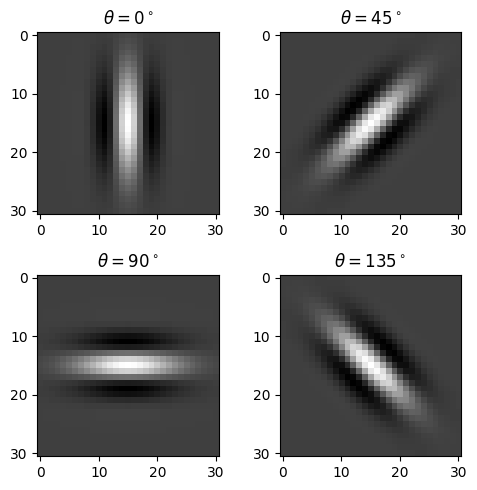

In [3]:
plt.figure(figsize=(5,5))
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(r"$\theta=$"+str(i*45)+r"$^\circ$")
    plt.imshow(gabor[i], cmap="gray")
plt.tight_layout()

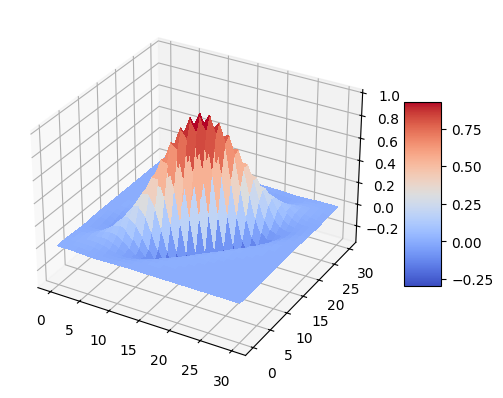

In [4]:
# Interactive 3D plot (as shown in the lecture)

# %matplotlib widget
# Note: if you get an error, try using `%matplotlib widget` instead

from matplotlib import cm
X = np.arange(kernelwidth+1)
Y = np.arange(kernelwidth+1)
X, Y = np.meshgrid(X, Y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, gabor[i], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

##### Run the code below to download the dataset: 

In [5]:
# Download the dataset from original paper source at http://www.rctn.org/bruno/sparsenet/
# Note you can also use curl, if wget is not installed (e.g. on MacOS)
!curl  "-O" "https://www.rctn.org/bruno/sparsenet/IMAGES.mat"
!curl  "-O" "https://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat"
# !wget "http://www.rctn.org/bruno/sparsenet/IMAGES.mat"
# !wget "http://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat"
mat_images = sio.loadmat('IMAGES.mat')
imgs = mat_images['IMAGES']
mat_images_raw = sio.loadmat('IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.0M  100 20.0M    0     0  2243k      0  0:00:09  0:00:09 --:--:-- 3869k  0  0:00:43  0:00:02  0:00:41  474k8k    0     0  1053k      0  0:00:19  0:00:05  0:00:14 1231k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.0M  100 20.0M    0     0  6796k      0  0:00:03  0:00:03 --:--:-- 6797k


In [6]:
imgs_raw.shape, imgs.shape

((512, 512, 10), (512, 512, 10))

In [7]:
# What are the dimensions?
np.shape(imgs)

(512, 512, 10)

##### Run the code below to visualize raw images from the dataset:

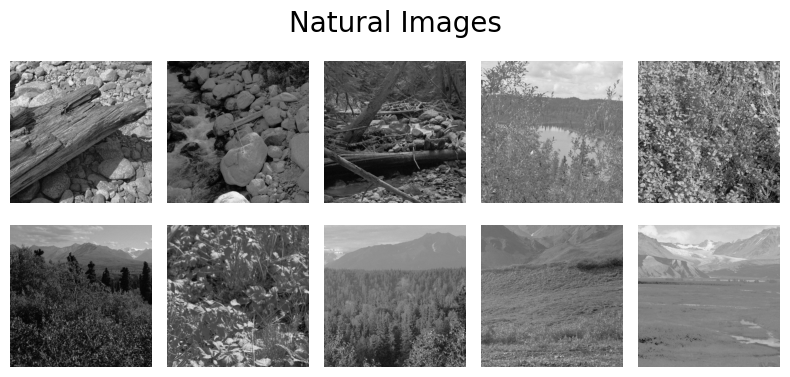

In [8]:
# Plot examle natural images

fig = plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs_raw[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9) 

##### Apply each of the pre-defined Gabor Kernels to a single image from the dataset and visualize the output

In [9]:
single_image = imgs_raw[:, :, 0]
out = []
for i in range(4):
    # TODO: use OpenCV to apply each of the pre-defined Gabor Kernels to the selected single image (~1 line):
    out_image = cv2.filter2D(single_image, -1, gabor[i])
    out.append(out_image)

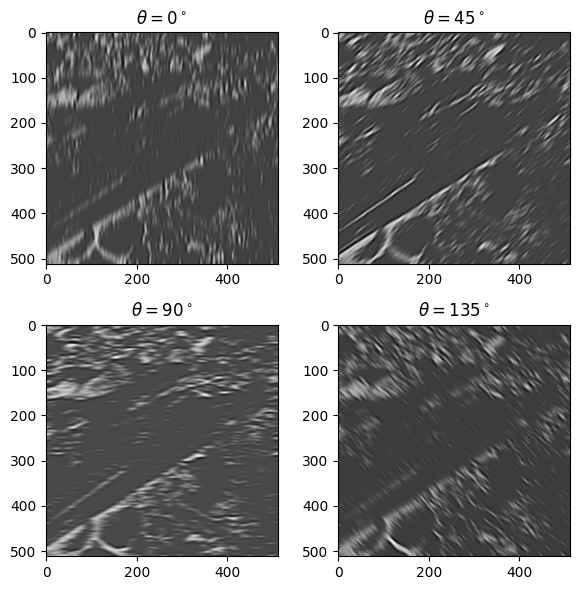

In [10]:
plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(r"$\theta=$"+str(i*45)+r"$^\circ$")
    plt.imshow(out[i], cmap="gray")
plt.tight_layout()

In [11]:
# Extract images patches

# Simulation constants
H, W, num_images = imgs_raw.shape
patchs_list = []

# TODO: specify the number of parameters (eg. 15000) and path size (eg. 16 x 16) (~2 lines):
num_patches = 15000
w, h = 16, 16


pl=[]

# Generate image patches
for patch in tqdm(range(num_patches)):
    # Get the coordinates of the upper left corner of for cropping images randomly.
    beginx = np.random.randint(0, W-w-1)
    beginy = np.random.randint(0, H-h-1)
    
    # TODO: Get index of a random image from the dataset (~1 line):
    idx = np.random.randint(0, num_images)
    
    img_cropped = imgs_raw[beginy:beginy+h, beginx:beginx+w, idx]
    
    patchs_list.append(img_cropped.flatten())
    
    img_c=imgs[beginy:beginy+h, beginx:beginx+w, idx]
    pl.append(img_c.flatten())
    
processed_patches=np.array(pl)

patches = np.array(patchs_list)

  0%|          | 0/15000 [00:00<?, ?it/s]

### 3. Principal Components Analysis (PCA)

Next, we consider **Principal Component Analysis (PCA)**, an unsupervised learning method that finds an orthogonal basis for the data by identifying directions of maximal variance.

Given zero-mean data, PCA finds a set of mutually orthogonal basis functions $\{\phi_i\}$ such that the projected coefficients

$$
a_i = \boldsymbol{\phi}_i^\top \mathbf{x}
$$

capture the maximum possible variance subject to orthogonality constraints.

The first principal component solves

$$
\boldsymbol{\phi}_1 =
\arg\max_{\|\boldsymbol{\phi}\|=1}
\mathrm{Var}(\boldsymbol{\phi}^\top \mathbf{x}),
$$

and each subsequent component maximizes variance while remaining orthogonal to the previous components.

The resulting coefficients are pairwise decorrelated:

$$
\mathrm{Cov}(a_i, a_j) = 0
\quad \text{for } i \neq j.
$$

Equivalently, assuming zero-mean data,

$$
\langle a_i a_j \rangle = 0
\quad \text{for } i \neq j,
$$

where $\langle \cdot \rangle$ denotes expectation over the data distribution.

---

PCA is commonly used for dimensionality reduction by retaining only the leading principal components that explain the largest fraction of variance. In image processing, PCA can be applied to image p


In [12]:
from sklearn.decomposition import PCA

##### Run the PCA and plot the resulting filters:

  0%|          | 0/25 [00:00<?, ?it/s]

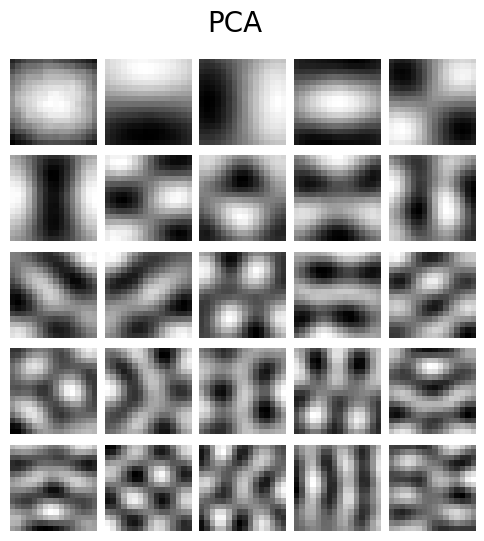

In [13]:
# TODO: initialize the PCA with the given number of components (~1 line):
n_comp = 25
pca = PCA(n_components=n_comp)
# TODO: fit the generated patches to the PCA (~1 line):
pca.fit(patches)
# TODO: get components from the PCA (~1 line):
pca_filters = pca.components_

# plot filters
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(n_comp)):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.reshape(pca_filters[i], (w, h)), cmap="gray")
    plt.axis("off")
plt.suptitle("PCA", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

Note that receptive fields found by PCA are not localized and the vast majority do not at all resemble cortical tuning curves.

### 4. Sparse coding network

We will use a computational model to simulate the learning of a sparse code for natural image patches. We assume that neurons in V1 start with random feedforward connections to the input, and that learning updates these connections to encourage **sparse** activity patterns in the code.

The search for a sparse code can be formulated as an optimization problem by minimizing the cost function

$$
E(\mathbf{a},\Phi)
=
\underbrace{\left\|\mathbf{I}-\Phi \mathbf{a}\right\|_2^2}_{\text{reconstruction error}}
+
\lambda\,
\underbrace{\sum_{i=1}^{M} \left|a_i\right|}_{\text{sparsity penalty}}.
\tag{2}
$$

Here, $\lambda>0$ controls the trade-off between reconstruction fidelity and sparsity. The first term measures how accurately the coefficients $\mathbf{a}$ and dictionary $\Phi$ reconstruct the input patch $\mathbf{I}$. The second term penalizes representations in which activity is spread across many coefficients, favoring codes in which only a few coefficients are active.

---

### Inference and Learning

For a fixed dictionary $\Phi$, we infer sparse coefficients $\mathbf{a}$ using an iterative **proximal gradient** (ISTA-style) update: a gradient step on the reconstruction error followed by **soft-thresholding** (the proximal operator of the $\ell_1$ penalty). For a step size $\eta>0$, the update is

$$
\mathbf{a}^{(t+\!1)}
=
\mathcal{S}_{\eta\lambda}
\!\left(
\mathbf{a}^{(t)} + \eta\,\Phi^\top\big(\mathbf{I}-\Phi \mathbf{a}^{(t)}\big)
\right),
$$

where the soft-thresholding operator is applied elementwise:

$$
\mathcal{S}_{\theta}(x) = \mathrm{sign}(x)\,\max(|x|-\theta,\,0).
$$

After the coefficients have (approximately) converged for a given batch of patches, we update the dictionary $\Phi$ by gradient descent on the reconstruction error:

$$
\Phi \leftarrow \Phi + \eta_\Phi\,(\mathbf{I}-\Phi\mathbf{a})\,\mathbf{a}^\top,
$$

followed by a column-wise normalization of $\Phi$ to keep the dictionary elements well-scaled.

---

### Sparse Coding Network (Architecture)

Implement a sparse coding network with:
- **Input:** a randomly sampled $16\times 16$ image patch, vectorized as $\mathbf{I}\in\mathbb{R}^{256}$.
- **Code layer:** $M=25$ units that produce a sparse representation $\mathbf{a}\in\mathbb{R}^{25}$.
- **Dictionary:** $\Phi \in \mathbb{R}^{256\times 25}$ maps code coefficients back to the input space.

*Note:* The Local Competitive Algorithm (LCA) proposed by Rozell et al. (2008) implements a closely related inference objective using continuous-time dynamics with lateral inhibition. In this exercise we use the simpler discrete-time proximal-gradient (thresholding) inference shown above.

For details on LCA, see:
Sparse coding via thresholding and local competition in neural circuits by Rozell, Johnson, Baraniuk, and Olshausen
https://pubmed.ncbi.nlm.nih.gov/18439138/


In [14]:
class SparseCodingNetwork:
    def __init__(self, num_inputs, num_units, batch_size, lr_a=1e-2, lr_Phi=1e-2, lmda=5e-3):
        self.lr_a = lr_a
        self.lr_Phi = lr_Phi
        self.lmda = lmda

        self.num_inputs = num_inputs
        self.num_units = num_units
        self.batch_size = batch_size

        # weights initialization (dictionary)
        Phi = np.random.randn(self.num_inputs, self.num_units).astype(np.float32)
        self.Phi = Phi * np.sqrt(1 / self.num_units)
        self.initialize_states()

    def initialize_states(self):
        self.a = np.zeros((self.batch_size, self.num_units), dtype=np.float32)

    def normalize_columns(self):
        """Normalize dictionary elements (columns of Phi) to unit norm."""
        self.Phi = self.Phi / np.maximum(
            np.linalg.norm(self.Phi, ord=2, axis=0, keepdims=True), 1e-8
        )

    def soft_thresholding_func(self, x, thresh):
        """Soft-thresholding (prox for |x|)."""
        return np.maximum(x - thresh, 0) - np.maximum(-x - thresh, 0)

    def calculate_total_error(self, error):
        recon_error = np.mean(error**2)
        sparsity_a = self.lmda * np.mean(np.abs(self.a))
        return recon_error + sparsity_a

    def __call__(self, inputs, training=True):
        # reconstruction error
        error = inputs - self.a @ self.Phi.T

        # ISTA / proximal gradient inference step
        a = self.a + self.lr_a * (error @ self.Phi)
        self.a = self.soft_thresholding_func(a, self.lmda)

        if training:
            error = inputs - self.a @ self.Phi.T
            dPhi = (error.T @ self.a)
            self.Phi += self.lr_Phi * dPhi

        return error, self.a


### 5. Run simulation

##### Specify the simulation constants and initialize the model:

In [15]:
# Simulation constants
H, W, num_images = imgs_raw.shape

# TODO: specify the number of iterations (eg. 100) maximum number of simulation time (eg. 1000s) and batch size (eg. 250) (trivial, ~3 lines):
num_iter = 100 
nt_max = 1000 
batch_size = 250 

# TODO: specify the image patch size (eg. 16) and the number of neurons (eg. 25) (trivial, ~2 lines):
sz = 16 
num_units = 25 

num_inputs = sz**2
eps = 1e-3 # small value which determines convergence
error_list = [] # List to save errors

# TODO: initialize the SparseCodingNetwork with the desired numuber of inputs, units and batch size (~1 line):
model = SparseCodingNetwork(
    num_inputs=sz**2, 
    num_units=num_units, 
    batch_size=batch_size,
    # lmda=5e-5,
    # lr_a=1e-2,
    # lr_Phi=1e-4
)

##### Implement code to run the simulation:

In [16]:
# Run simulation
for iter_ in tqdm(range(num_iter)):
    # Get the coordinates of the upper left corner of cropping image randomly.
    beginx = np.random.randint(0, W - sz + 1, batch_size)
    beginy = np.random.randint(0, H - sz + 1, batch_size)

    inputs_list = []
    for i in range(batch_size):

        # Get index of a random image from the dataset
        idx = np.random.randint(0, num_images)

        img = imgs[:, :, idx]
        crop = img[beginy[i]:beginy[i] + sz, beginx[i]:beginx[i] + sz].flatten()
        inputs_list.append(crop - np.mean(crop))

    inputs = np.asarray(inputs_list, dtype=np.float32)  # Input image patches

    # Reset (initialize) states of the model
    model.initialize_states()

    # Normalize dictionary (this normalizes columns given axis=0 in your implementation)
    model.normalize_columns()

    # Initialize previous activity (copy to avoid aliasing)
    a_tm1 = model.a.copy()

    for t in range(nt_max):
        # Update a without updating weights
        error, a = model(inputs, training=False)

        # Compute the difference between current and previous a
        da = a - a_tm1

        da_norm = np.linalg.norm(da, ord=2) / (eps + np.linalg.norm(a_tm1, ord=2))
        a_tm1 = a  # update a_tm1

        # Check convergence of a, then update weights
        if da_norm < eps:
            # Update a with weights update
            error, a = model(inputs, training=True)
            break

        # If failure to converge, break and print error
        if t == nt_max - 1:
            print("Error at patch:", iter_)
            print(da_norm)
            break

    error_list.append(model.calculate_total_error(error))  # Append errors

    # Print moving average error (include current iteration)
    if iter_ % 100 == 99:
        print(
            "iter: " + str(iter_ + 1) + "/" + str(num_iter) +
            ", Moving error:", np.mean(error_list[iter_ - 99:iter_ + 1])
        )


  0%|          | 0/100 [00:00<?, ?it/s]

iter: 100/100, Moving error: 0.05915331602225245


### 6. Evaluate performance

##### Run the following code to plot the error across the iterations:

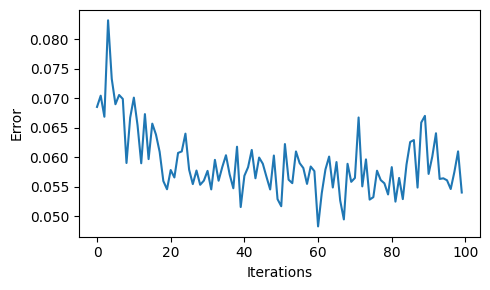

In [17]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), np.array(error_list))
plt.tight_layout()
plt.show()

##### Run the following code to plot the resulting receptive fields:

  0%|          | 0/25 [00:00<?, ?it/s]

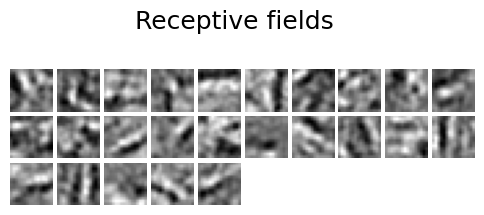

In [18]:
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(num_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=18)
plt.show()

### 7. Conclusion

The presented results show that the sparse model learns to extract simple features from natural images, these receptive fields are similar to the receptive fields of simple cells in the visual cortex. The model provides a plausible explanation for how the visual system might learn to represent complex visual information with a relatively small number of neurons. The result suggests that this type of sparse coding may be a general principle of sensory processing in the brain.

For more detail on this topic, please see the source work by [Olshausen, B. A., & Field, D. J. (1996). Emergence of simple-cell receptive field properties by learning a sparse code for natural images. Nature, 381(6583), 607–609.](https://www.nature.com/articles/381607a0). 

##### Congratulations! You have finished this week's problem set on learning a sparse code for natural images!